8A. Created RNG.

8B. Generated response vector.

8C. Forward stepwise based on Cp the model uses X1, X2, X3, X4, X6. Or Y = 1.8 + 1.6X1 + 0.1X2 + 0.3X3 - 0.5X4 + 0.1X6

8D. Backward stepwise based on Cp the model uses X1, X3, X4, X6. Or Y = 1.8 + 1.6X1 + 0.3X3 - 0.4X4 + 0.05X6

8E. Optimal lambda 0.022. So Y = 1.1 + 1.2X1 - 0.7X2 + 1.2X3 - 0.4X4

    LASSO Coefficients (corresponding to X1 to X10):

    X1: 1.249989
    
    X2: -0.714156
    
    X3: 1.158486
    
    X4: -0.362833
    
    X5: 0.000000
    
    X6: -0.000000
    
    X7: 0.000000
    
    X8: 0.000000
    
    X9: 0.000000
    
    X10: 0.000000
    
    Intercept: 1.139334

8F. Forward stepwise selects X7 and X6. Or Y = 1.97 + 3.00X7 - 0.01X6

    Lasso: Y = 10.6 - 1.1X1 - 0.96X4 + 40.1X5 + 222.5X7 + 60.4X9 

    Optimal lambda (alpha): 0.321

    LASSO Coefficients (corresponding to X1 to X10):

    X1: -1.058904
    
    X2: -0.000000
    
    X3: 0.000000
    
    X4: -0.964748
    
    X5: 40.087946
    
    X6: -0.000000
    
    X7: 222.498360
    
    X8: -0.000000
    
    X9: 60.371555
    
    X10: -0.000000

    Intercept: 10.594426



Libraries

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


Creating random number generator

PART A.

In [2]:


seed = 8555
rng = np.random.default_rng(seed)

n = 100

X = rng.normal(loc=0, scale=1, size=n)

e = rng.normal(loc=0,scale=1, size=n)




Generate a response vector Y 

PART B

In [3]:
B0 = 2.0
B1 = 1.5
B2 = -0.8
B3 = 0.3

Y = B0 + B1 * X + B2 * (X**2) + B3 * (X**3) + e

Forward Stepwise Selection AIC method

In [4]:

data = pd.DataFrame({'X{}'.format(i): X**i for i in range(1, 11)})
data['Y'] = Y

# Forward stepwise with AIC
def forward_stepwise(data, response, max_features=10):
    remaining = list(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = np.inf, np.inf
    best_model = None

    while remaining and len(selected) < max_features:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {}".format(response, ' + '.join(selected + [candidate]))
            model = sm.OLS.from_formula(formula, data).fit()
            aic = model.aic 
            scores_with_candidates.append((aic, candidate, model))
        
        scores_with_candidates.sort()
        best_new_score, best_candidate, best_model_candidate = scores_with_candidates[0]
        
        if best_new_score < current_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
            best_model = best_model_candidate
        else:
            break  

    return best_model, selected

# Model Selection
final_model, selected_predictors = forward_stepwise(data, 'Y')

# Display predictors and summary
print("Selected predictors:", selected_predictors)
print("\nModel Coefficients:\n", final_model.params)
print("\nModel Summary:\n", final_model.summary())



Selected predictors: ['X1', 'X2', 'X3', 'X4', 'X6']

Model Coefficients:
 Intercept    1.760709
X1           1.567606
X2           0.099275
X3           0.290100
X4          -0.483018
X6           0.051065
dtype: float64

Model Summary:
                             OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     145.1
Date:                Sun, 16 Mar 2025   Prob (F-statistic):           1.34e-42
Time:                        14:30:36   Log-Likelihood:                -132.72
No. Observations:                 100   AIC:                             277.4
Df Residuals:                      94   BIC:                             293.1
Df Model:                           5                                         
Covariance Type:            nonrobust              

CP method

PART C

In [5]:


data = pd.DataFrame({'X{}'.format(i): X**i for i in range(1, 11)})
data['Y'] = Y

# Full model to estimate error 
full_formula = 'Y ~ ' + ' + '.join(['X{}'.format(i) for i in range(1, 11)])
full_model = sm.OLS.from_formula(full_formula, data).fit()
sigma2_full = full_model.mse_resid  
n = len(data) 
print(f"Estimated sigma^2 from full model: {sigma2_full:.4f}")

# Cp function
def Cp(estimator, sigma2_full, n, p):
    RSS = np.sum(estimator.resid ** 2)
    cp = RSS / sigma2_full - (n - 2 * p)
    return cp

# Forward Stepwise with Cp
def forward_stepwise_cp(data, response, sigma2_full, max_features=10):
    remaining = list(data.columns)
    remaining.remove(response)
    selected = []
    current_best_cp = np.inf  
    best_model = None

    while remaining and len(selected) < max_features:
        candidate_scores = []
        for candidate in remaining:
            predictors = selected + [candidate]
            formula = "{} ~ {}".format(response, ' + '.join(predictors))
            model = sm.OLS.from_formula(formula, data).fit()
            p = model.df_model + 1  
            cp = Cp(model, sigma2_full, n, p)
            candidate_scores.append((cp, candidate, model))

        # Select lowest Cp
        candidate_scores.sort()
        best_cp, best_candidate, best_model_candidate = candidate_scores[0]

        # Check for improvement of Cp
        if best_cp < current_best_cp:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_best_cp = best_cp
            best_model = best_model_candidate
            print(f"Selected: {best_candidate}, Cp: {best_cp:.4f}")
        else:
            print("No further improvement in Cp")
            break  

    return best_model, selected

# Forward Stepwise final model using Cp
final_model_cp, selected_predictors_cp = forward_stepwise_cp(data, 'Y', sigma2_full)

print("\nFinal selected predictors based on Cp:", selected_predictors_cp)
print("\nFinal model coefficients:\n", final_model_cp.params)
print("\nFinal model summary:\n", final_model_cp.summary())


Estimated sigma^2 from full model: 0.9259
Selected: X1, Cp: 153.8355
Selected: X2, Cp: 49.9617
Selected: X3, Cp: 2.8466
Selected: X4, Cp: 2.5062
Selected: X6, Cp: 1.8989
No further improvement in Cp

Final selected predictors based on Cp: ['X1', 'X2', 'X3', 'X4', 'X6']

Final model coefficients:
 Intercept    1.760709
X1           1.567606
X2           0.099275
X3           0.290100
X4          -0.483018
X6           0.051065
dtype: float64

Final model summary:
                             OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     145.1
Date:                Sun, 16 Mar 2025   Prob (F-statistic):           1.34e-42
Time:                        14:30:40   Log-Likelihood:                -132.72
No. Observations:                 100   AIC:              

Backwards stepwise Cp method

PART D

In [6]:


data = pd.DataFrame({'X{}'.format(i): X**i for i in range(1, 11)})
data['Y'] = Y

# Full model to estimate error 
full_formula = 'Y ~ ' + ' + '.join(['X{}'.format(i) for i in range(1, 11)])
full_model = sm.OLS.from_formula(full_formula, data).fit()
sigma2_full = full_model.mse_resid 
n = len(data)  
print(f"Estimated sigma^2 from full model: {sigma2_full:.4f}")

# Cp function 
def Cp(estimator, sigma2_full, n, p):
    RSS = np.sum(estimator.resid ** 2)
    cp = RSS / sigma2_full - (n - 2 * p)
    return cp

# Backward Stepwise using Cp
def backward_stepwise_cp(data, response, sigma2_full, min_features=1):
    selected = list(data.columns)
    selected.remove(response)  
    current_best_cp = np.inf  
    best_model = None

    while len(selected) > min_features:
        candidate_scores = []
        for candidate in selected:
            predictors = [p for p in selected if p != candidate]
            formula = "{} ~ {}".format(response, ' + '.join(predictors))
            model = sm.OLS.from_formula(formula, data).fit()
            p = model.df_model + 1  
            cp = Cp(model, sigma2_full, n, p)
            candidate_scores.append((cp, candidate, model))

        # Select lowest Cp
        candidate_scores.sort()
        best_cp, worst_candidate, best_model_candidate = candidate_scores[0]

        # Check for lowest Cp
        if best_cp < current_best_cp:
            selected.remove(worst_candidate)
            current_best_cp = best_cp
            best_model = best_model_candidate
            print(f"Removed: {worst_candidate}, Cp: {best_cp:.4f}")
        else:
            print("No further improvement in Cp")
            break  

    return best_model, selected

# Run Backward Stepwise model using Cp
final_model_cp, selected_predictors_cp = backward_stepwise_cp(data, 'Y', sigma2_full)

print("\nFinal selected predictors based on Cp:", selected_predictors_cp)
print("\nFinal model coefficients:\n", final_model_cp.params)
print("\nFinal model summary:\n", final_model_cp.summary())


Estimated sigma^2 from full model: 0.9259
Removed: X7, Cp: 9.0000
Removed: X8, Cp: 7.0000
Removed: X10, Cp: 5.0011
Removed: X2, Cp: 3.2064
Removed: X9, Cp: 1.4859
Removed: X5, Cp: -0.0582
No further improvement in Cp

Final selected predictors based on Cp: ['X1', 'X3', 'X4', 'X6']

Final model coefficients:
 Intercept    1.785106
X1           1.550734
X3           0.301312
X4          -0.431238
X6           0.045207
dtype: float64

Final model summary:
                             OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     183.2
Date:                Sun, 16 Mar 2025   Prob (F-statistic):           9.49e-44
Time:                        14:30:44   Log-Likelihood:                -132.75
No. Observations:                 100   AIC:                        

AIC method

In [7]:


data = pd.DataFrame({'X{}'.format(i): X**i for i in range(1, 11)})
data['Y'] = Y

# Backward Stepwise with AIC
def backward_stepwise(data, response, min_features=1):
    selected = list(data.columns)
    selected.remove(response) 
    current_best_aic = np.inf
    best_model = None

    # Fit full model 
    formula = "{} ~ {}".format(response, ' + '.join(selected))
    full_model = sm.OLS.from_formula(formula, data).fit()
    current_best_aic = full_model.aic
    best_model = full_model
    print(f"Starting AIC with all predictors: {current_best_aic:.4f}")

    # Elimination loop
    while len(selected) > min_features:
        candidate_scores = []
        for candidate in selected:
            predictors = [p for p in selected if p != candidate]
            formula = "{} ~ {}".format(response, ' + '.join(predictors))
            model = sm.OLS.from_formula(formula, data).fit()
            aic = model.aic
            candidate_scores.append((aic, candidate, model))

        # Select the model with the lowest AIC 
        candidate_scores.sort()
        best_new_aic, worst_candidate, best_model_candidate = candidate_scores[0]

        # Check AIC's
        if best_new_aic < current_best_aic:
            selected.remove(worst_candidate)
            current_best_aic = best_new_aic
            best_model = best_model_candidate
            print(f"Removed: {worst_candidate}, AIC: {best_new_aic:.4f}")
        else:
            print("No further improvement in AIC")
            break  

    return best_model, selected

# Run Backward Stepwise model with AIC
final_model, selected_predictors = backward_stepwise(data, 'Y')

print("\nFinal selected predictors based on AIC:", selected_predictors)
print("\nFinal model coefficients:\n", final_model.params)
print("\nFinal model summary:\n", final_model.summary())


Starting AIC with all predictors: 286.4392
Removed: X7, AIC: 284.4392
Removed: X8, AIC: 282.4392
Removed: X10, AIC: 280.4404
Removed: X2, AIC: 278.6708
Removed: X9, AIC: 276.9837
Removed: X5, AIC: 275.4919
No further improvement in AIC

Final selected predictors based on AIC: ['X1', 'X3', 'X4', 'X6']

Final model coefficients:
 Intercept    1.785106
X1           1.550734
X3           0.301312
X4          -0.431238
X6           0.045207
dtype: float64

Final model summary:
                             OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     183.2
Date:                Sun, 16 Mar 2025   Prob (F-statistic):           9.49e-44
Time:                        14:30:48   Log-Likelihood:                -132.75
No. Observations:                 100   AIC:    

Fitting Lasso model to the simulated data

PART E

C:\Users\jacob\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09923496219755634, tolerance: 0.06789455708033337
  model = cd_fast.enet_coordinate_descent_gram(


Optimal lambda (alpha): 0.022232

LASSO Coefficients (corresponding to X1 to X10):
X1: 1.249989
X2: -0.714156
X3: 1.158486
X4: -0.362833
X5: 0.000000
X6: -0.000000
X7: 0.000000
X8: 0.000000
X9: 0.000000
X10: 0.000000

Intercept: 1.139334


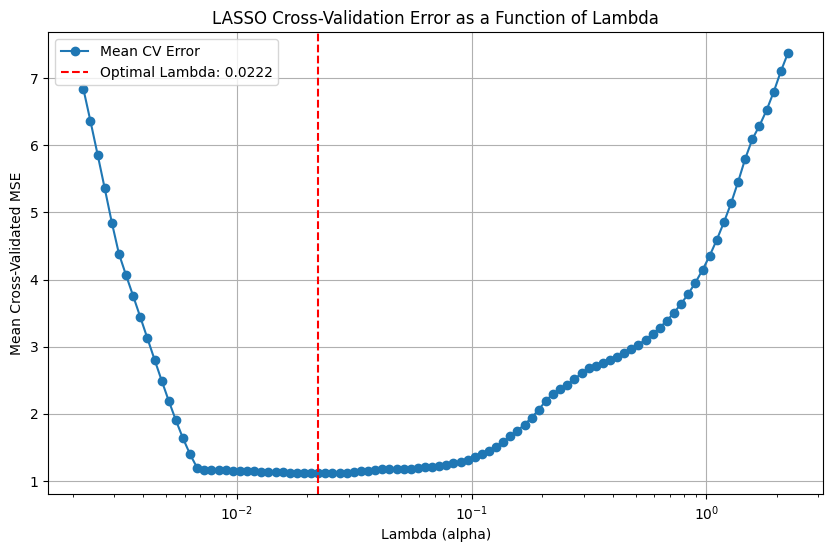

In [8]:


X_data = pd.DataFrame({'X{}'.format(i): X**i for i in range(1, 11)})  # Predictors X1 to X10
Y_data = Y  

# Standardize predictors 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_data)  

# LASSO with 10-fold cross validation
lasso_cv = LassoCV(cv=10, random_state=8555).fit(X_scaled, Y_data)


# Optimal lambda 
optimal_lambda = lasso_cv.alpha_
print(f"Optimal lambda (alpha): {optimal_lambda:.6f}")

# Coefficients
lasso_coefficients = lasso_cv.coef_
print("\nLASSO Coefficients (corresponding to X1 to X10):")
for i, coef in enumerate(lasso_coefficients, 1):
    print(f"X{i}: {coef:.6f}")

# Intercept
print(f"\nIntercept: {lasso_cv.intercept_:.6f}")


# Plot Cross-Validation Error vs Lambda
mean_mse = np.mean(lasso_cv.mse_path_, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(lasso_cv.alphas_, mean_mse, marker='o', label='Mean CV Error')
plt.axvline(lasso_cv.alpha_, color='red', linestyle='--', label=f'Optimal Lambda: {lasso_cv.alpha_:.4f}')
plt.xlabel('Lambda (alpha)')
plt.ylabel('Mean Cross-Validated MSE')
plt.title('LASSO Cross-Validation Error as a Function of Lambda')
plt.xscale('log')  
plt.legend()
plt.grid(True)
plt.show()


New response vector forward stepwise

PART F

In [9]:

B0 = 2.0
B7 = 3.0

Y = B0 + B7 * X**7 + e  

data = pd.DataFrame({'X{}'.format(i): X**i for i in range(1, 11)})
data['Y'] = Y

# Full model to estimate error 
full_formula = 'Y ~ ' + ' + '.join(['X{}'.format(i) for i in range(1, 11)])
full_model = sm.OLS.from_formula(full_formula, data).fit()
sigma2_full = full_model.mse_resid  
n = len(data)  
print(f"Estimated sigma^2 from full model: {sigma2_full:.4f}")

# Cp function
def Cp(estimator, sigma2_full, n, p):
    RSS = np.sum(estimator.resid ** 2)
    cp = RSS / sigma2_full - (n - 2 * p)
    return cp

# Forward Stepwise using Cp
def forward_stepwise_cp(data, response, sigma2_full, max_features=10):
    remaining = list(data.columns)
    remaining.remove(response)
    selected = []
    current_best_cp = np.inf 
    best_model = None

    while remaining and len(selected) < max_features:
        candidate_scores = []
        for candidate in remaining:
            predictors = selected + [candidate]
            formula = "{} ~ {}".format(response, ' + '.join(predictors))
            model = sm.OLS.from_formula(formula, data).fit()
            p = model.df_model + 1  
            cp = Cp(model, sigma2_full, n, p)
            candidate_scores.append((cp, candidate, model))

        # Select lowest Cp
        candidate_scores.sort()
        best_cp, best_candidate, best_model_candidate = candidate_scores[0]

        # Check for lowest Cp
        if best_cp < current_best_cp:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_best_cp = best_cp
            best_model = best_model_candidate
            print(f"Selected: {best_candidate}, Cp: {best_cp:.4f}")
        else:
            print("No further improvement in Cp")
            break 

    return best_model, selected

# Run Forward Stepwise model with Cp
final_model_cp, selected_predictors_cp = forward_stepwise_cp(data, 'Y', sigma2_full)

print("\nFinal selected predictors based on Cp:", selected_predictors_cp)
print("\nFinal model coefficients:\n", final_model_cp.params)
print("\nFinal model summary:\n", final_model_cp.summary())


Estimated sigma^2 from full model: 0.9259
Selected: X7, Cp: 2.1923
Selected: X6, Cp: -0.3143
No further improvement in Cp

Final selected predictors based on Cp: ['X7', 'X6']

Final model coefficients:
 Intercept    1.978712
X7           3.002564
X6          -0.006565
dtype: float64

Final model summary:
                             OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.763e+06
Date:                Sun, 16 Mar 2025   Prob (F-statistic):          7.36e-247
Time:                        14:30:57   Log-Likelihood:                -134.79
No. Observations:                 100   AIC:                             275.6
Df Residuals:                      97   BIC:                             283.4
Df Model:                           2                        

Lasso with New response.

PART F

In [10]:


X_data = pd.DataFrame({'X{}'.format(i): X**i for i in range(1, 11)}) 
Y_data = Y  

# Standardize predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_data)  

# LASSO with 10-fold cross-validation
lasso_cv = LassoCV(cv=10, random_state=8555).fit(X_scaled, Y_data)


# Optimal lambda 
optimal_lambda = lasso_cv.alpha_
print(f"Optimal lambda (alpha): {optimal_lambda:.6f}")

# Coefficients
lasso_coefficients = lasso_cv.coef_
print("\nLASSO Coefficients (corresponding to X1 to X10):")
for i, coef in enumerate(lasso_coefficients, 1):
    print(f"X{i}: {coef:.6f}")

# Intercept
print(f"\nIntercept: {lasso_cv.intercept_:.6f}")

Optimal lambda (alpha): 0.321055

LASSO Coefficients (corresponding to X1 to X10):
X1: -1.058904
X2: -0.000000
X3: 0.000000
X4: -0.964748
X5: 40.087946
X6: -0.000000
X7: 222.498360
X8: -0.000000
X9: 60.371555
X10: -0.000000

Intercept: 10.594426
